# Explainable ML Implementation for Healthcare Diagnostics
This notebook demonstrates the application of Explainable ML techniques to predict diabetes using the Pima Indians Diabetes Dataset.

## 1. Introduction
The purpose of this notebook is to implement a Random Forest model to predict diabetes and explain its predictions using SHAP and LIME.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
import shap
import lime
import lime.lime_tabular
from sklearn.inspection import PartialDependenceDisplay
import math


## 2. Load and Understand Data
Load the Pima Indians Diabetes Dataset and preprocess it.

In [3]:
# https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

data = pd.read_csv('C:/Users/User/Documents/Explainable ML/diabetes.csv')

In [4]:
# displaying the first few rows of the dataset
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [5]:
# Information of dataset 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Summary statistics of dataset
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [7]:
# Calculate min, max, and range
min_values = data.min()
max_values = data.max()
range_values = max_values - min_values

# Create a new DataFrame to display the results
summary_df = pd.DataFrame({
    'Min': min_values,
    'Max': max_values,
    'Range': range_values
})

print(summary_df)


                             Min     Max    Range
Pregnancies                0.000   17.00   17.000
Glucose                    0.000  199.00  199.000
BloodPressure              0.000  122.00  122.000
SkinThickness              0.000   99.00   99.000
Insulin                    0.000  846.00  846.000
BMI                        0.000   67.10   67.100
DiabetesPedigreeFunction   0.078    2.42    2.342
Age                       21.000   81.00   60.000
Outcome                    0.000    1.00    1.000


In [8]:
# Checking for missing values
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [10]:
# Correlation between the different characteristics. Closer to 1 better is the correlation.

corr_matrix_pearson = data.corr(method='pearson')
corr_matrix_pearson

Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683                 -0.033523   
Glucose                   0.331357  0.221071                  0.137337   
BloodPressure             0.088933  0.281805                  0.041265   
SkinThickness             0.436783  0.392573                  0.183928   
Insulin                   1.000000  0.197859                  0.185071   
BMI                       0.197859  1.000000                  0.140647   
DiabetesPedigreeFunction  0.185071  0.140647                  1.000000   
Age                      -0.042163  0.036242                  0.033561   
Outcome                   0.130548  0.292695                  0.173844   

                               Age   Outcome  
Pregnancies               0.544341  0.221898  
Glucose                   0.263514  0.466581  
BloodPressure             0.239528  0.065068  
SkinThickness            -0.113970  0.074752  
Insulin                  -0.042163  0.130548  
BMI                       0.036242  0.292695  
DiabetesPedigreeFunction  0.033561  0.173844  
Age                       1.000000  0.238356  
Outcome                   0.238356  1.000000

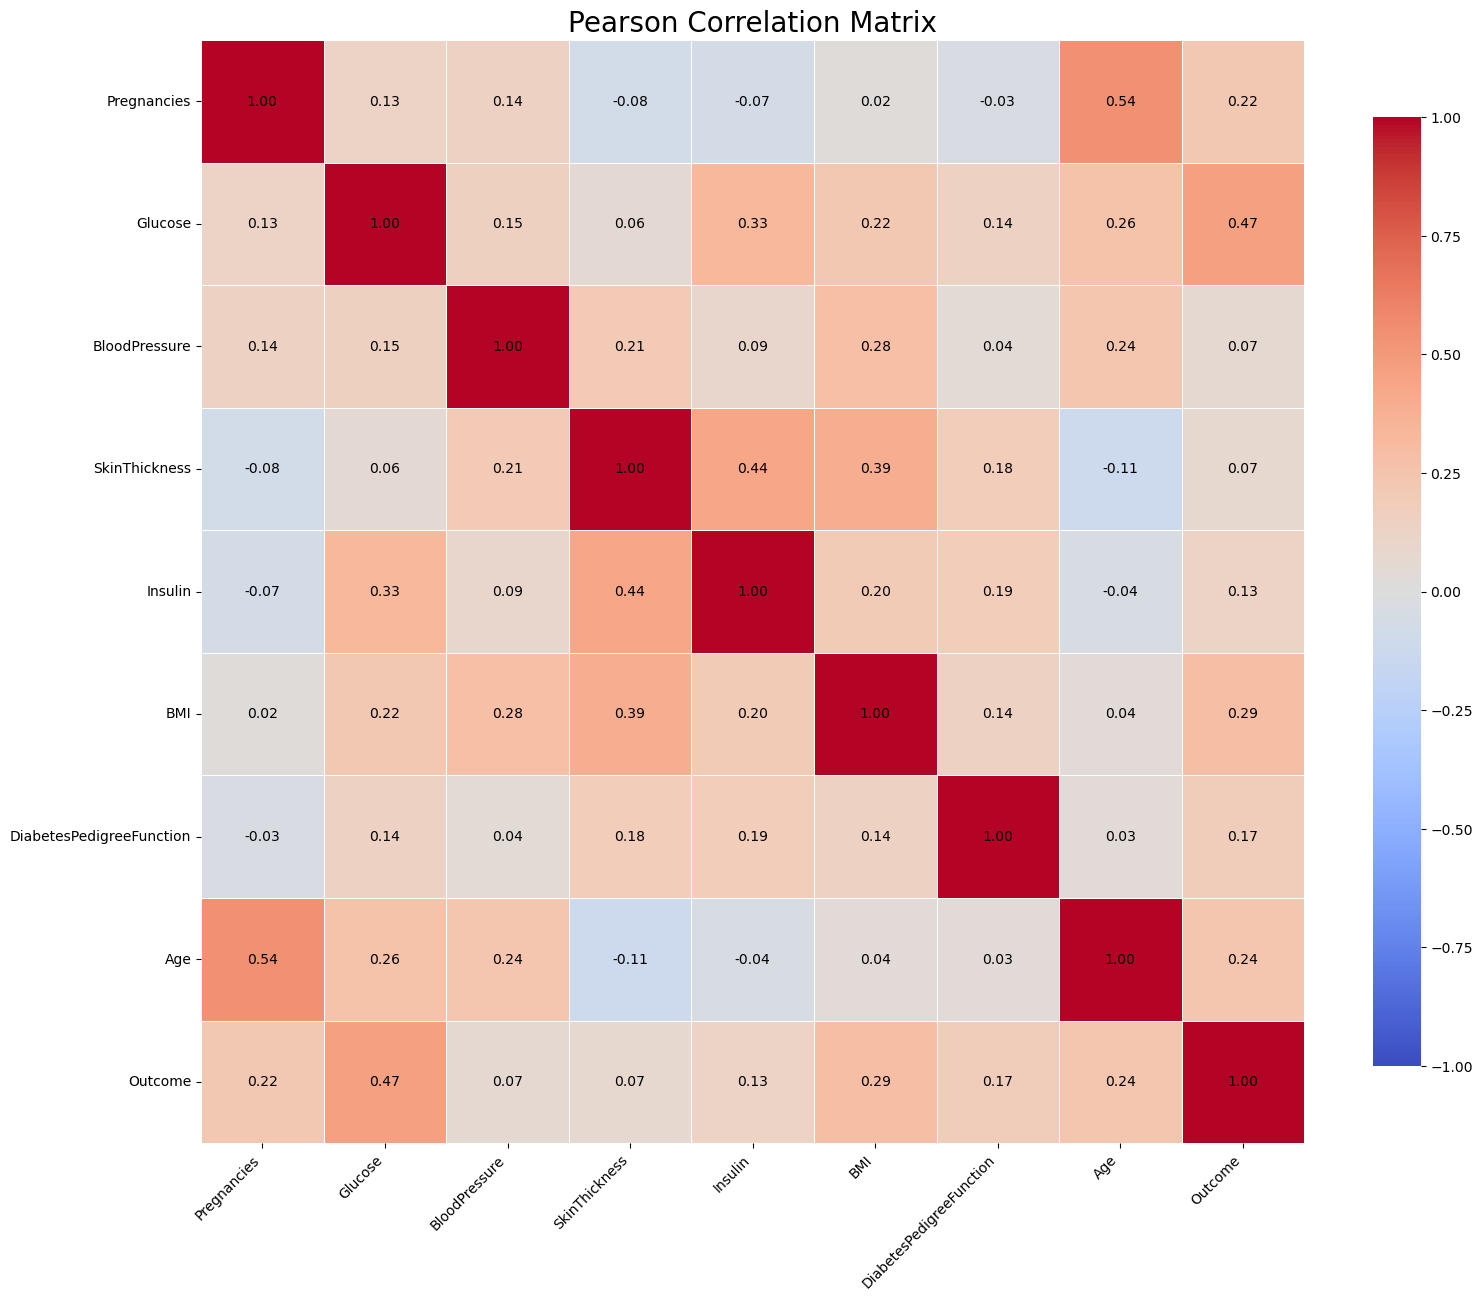

In [11]:
def annotate_heatmap(ax, data, fmt='.2f', **kwargs):
    """
    Annotate the heatmap with text labels.
    """
    data = data.round(2)  # Round the data if needed
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j + 0.5, i + 0.5, format(data.iloc[i, j], fmt),
                    ha='center', va='center', color='black', **kwargs)

plt.figure(figsize=(16, 14))  # Larger figure size for better readability
ax = sns.heatmap(
    corr_matrix_pearson,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .75},
    annot=False  # Disable default annotations
)
annotate_heatmap(ax, corr_matrix_pearson, fmt='.2f')
plt.title('Pearson Correlation Matrix', size=20)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)               # Rotate y-axis labels if needed
plt.tight_layout()                  # Adjust layout to fit labels
plt.show()


# 2. Splitting, Scaling and Re-sampling

In [12]:
# Feature and target split
X = data.drop("Outcome", axis=1)
y = data["Outcome"]


In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Scaling features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
y_train.value_counts()

Outcome
0    349
1    188
Name: count, dtype: int64

In [16]:
# Initialize the SMOTE object
smote = SMOTE(random_state=42)

# Fit and transform the training data
X_train_scaled_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

#Check balancing
y_train_res.value_counts()

Outcome
0    349
1    349
Name: count, dtype: int64

## 3. Hyperparameter Tuning using Bayesian Optimization
Use Bayesian optimization to find the best hyperparameters for the Random Forest model.

In [17]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV

# Define the model as XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Define parameter search space for Bayesian optimization
param_space = {
    'n_estimators': (10, 1000),
    'max_depth': (1, 50),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'gamma': (0, 10),
    'min_child_weight': (1, 10)
}

# Bayesian hyperparameter tuning
bayes_search = BayesSearchCV(model, param_space, n_iter=32, cv=3, random_state=42, n_jobs=-1)
bayes_search.fit(X_train_scaled_res, y_train_res)

# Best model after tuning
best_model_bayes = bayes_search.best_estimator_


c:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [18]:
# Predictions
y_pred = best_model_bayes.predict(X_test_scaled)


In [19]:
# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.73      0.83      0.77       133
           1       0.71      0.58      0.64        98

    accuracy                           0.72       231
   macro avg       0.72      0.70      0.71       231
weighted avg       0.72      0.72      0.72       231



In [20]:
# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"roc_auc: {f1:.2f}")

Accuracy: 0.72
Precision: 0.74
Recall: 0.72
F1 Score: 0.73
roc_auc: 0.73


## 4. Explainability with SHAP and LIME
Explain the model's predictions.

In [46]:
# load JS visualization code to notebook
shap.initjs()

# Calculate SHAP values
explainer = shap.TreeExplainer(best_model_bayes)
shap_values = explainer.shap_values(X_test)

In [47]:
# Print shap_values
print(shap_values)


[[-0.00644209  1.9784352  -0.16903801 ...  0.8205657  -0.18010083
   0.47379917]
 [-0.27921033  2.3855567  -0.43123874 ...  1.128356    0.12929037
   0.18410824]
 [-0.35012895  2.4497817  -0.56179136 ...  1.0561489   0.09656128
   0.21200316]
 ...
 [ 0.07722946  2.2254083  -0.1386886  ...  0.7570281  -0.35342622
   0.5965474 ]
 [-0.25630456  2.2672994  -0.25303635 ...  0.99897027  0.3996134
   0.49111852]
 [-0.17442274  2.3150184  -0.16875611 ...  1.0980384   0.20381634
   0.4784365 ]]


## SHAP force plot
####### A force plot is used to explain a single instance in the dataset

In [89]:
shap.force_plot(explainer.expected_value, shap_values[2, :], X_test.iloc[2, :])


In [49]:
shap.force_plot(explainer.expected_value, shap_values[100, :], X_test.iloc[100, :])


In [80]:
shap.force_plot(explainer.expected_value, shap_values[200, :], X_test.iloc[200, :])


In [81]:
shap.force_plot(explainer.expected_value, shap_values[:100, :], X_test.iloc[:100, :])


## SHAP Summary plot

#### Bar chart of mean importance

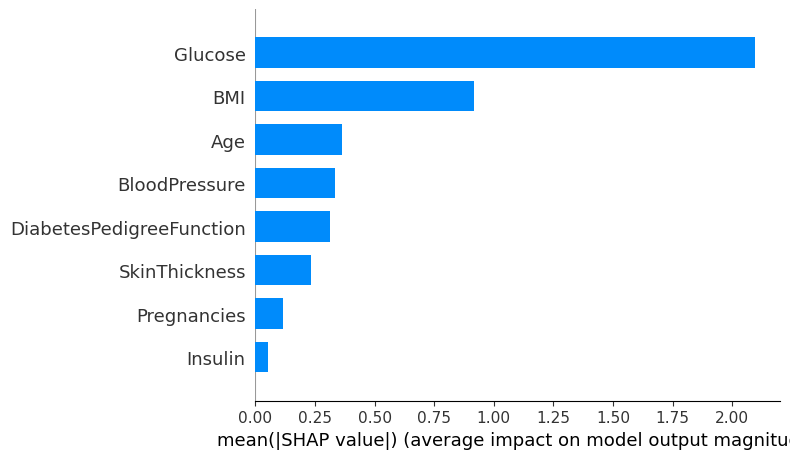

In [52]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Variable Importance Plot - Global Interpretation


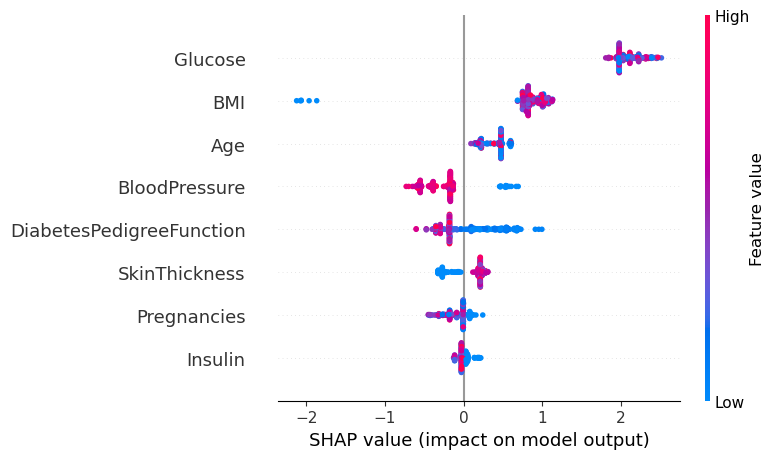

In [53]:
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test)

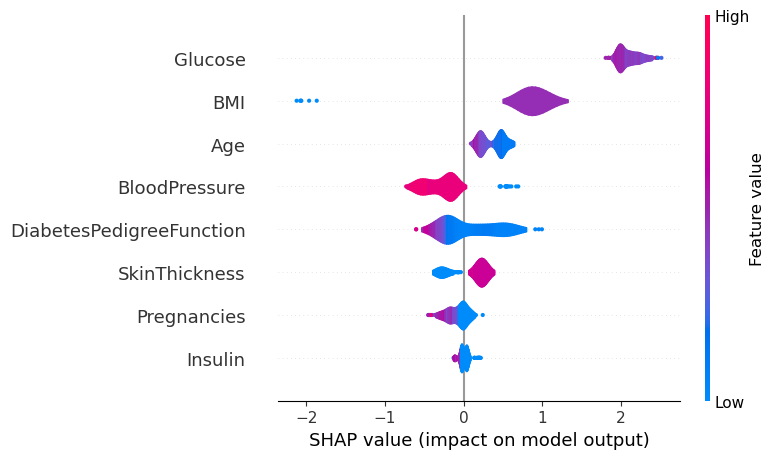

In [75]:
shap.summary_plot(shap_values, X_test, plot_type='violin')

## SHAP Dependence Plot

######## This plot shows the relationship between a single feature and the SHAP values, optionally conditioned on another feature. 


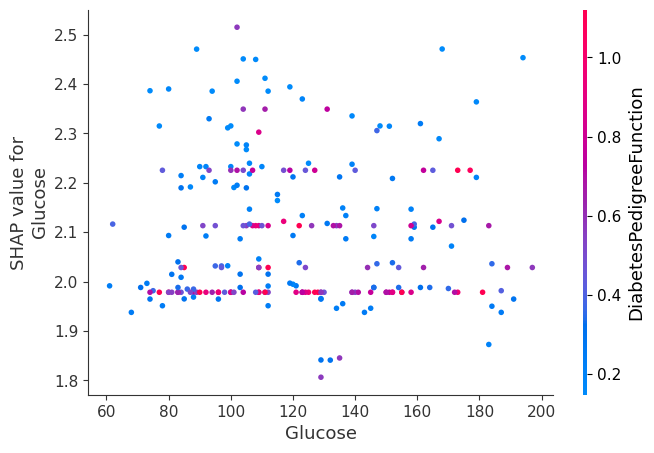

In [82]:
# SHAP dependence plot for a single feature
shap.dependence_plot("Glucose", shap_values, X_test)
plt.show()


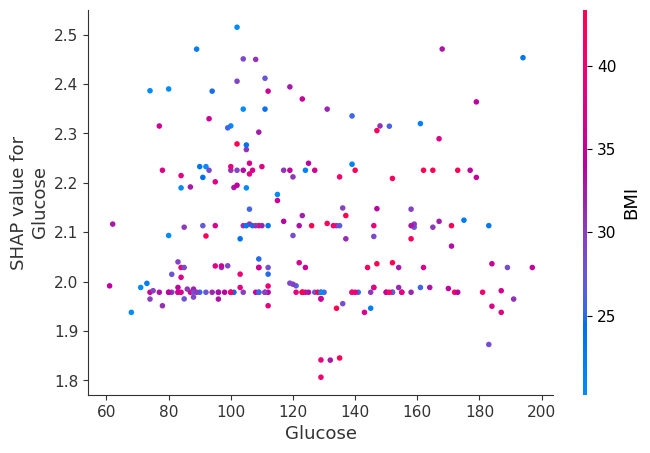

In [83]:
shap.dependence_plot("Glucose", shap_values, X_test, interaction_index="BMI")
plt.show()


## SHAP Decision Plot

This plot shows how the model arrives at a decision by cumulatively adding the contributions of each feature

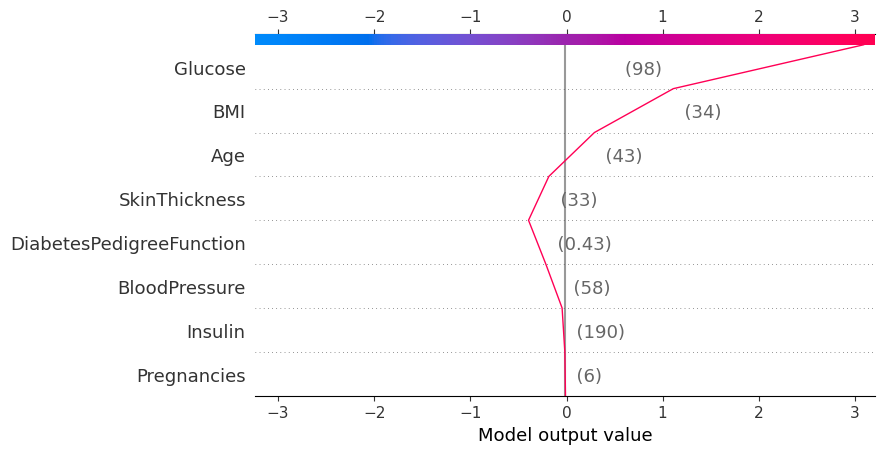

In [84]:
# SHAP decision plot for a single instance
shap.decision_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])
plt.show()


## SHAP Waterfall Plot

This plot shows the breakdown of a single prediction by the contribution of each feature.

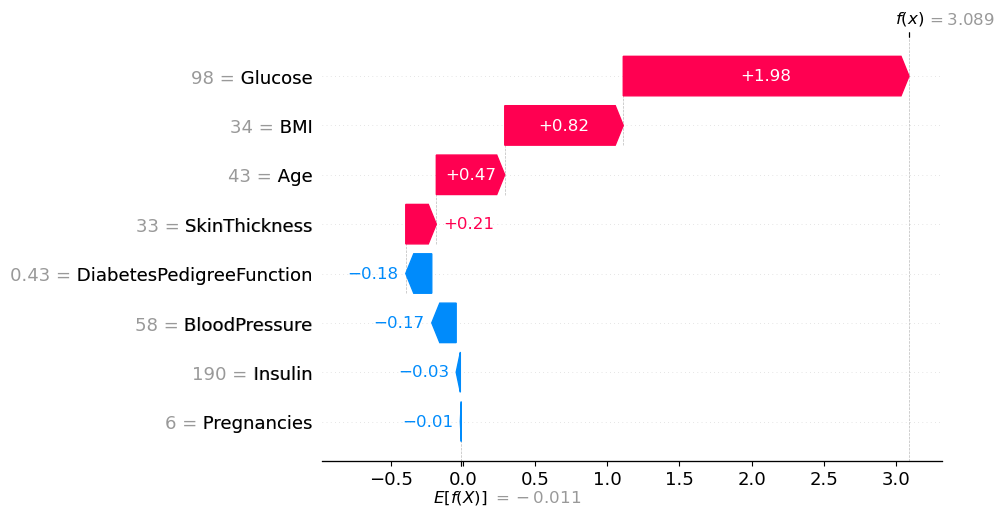

In [85]:
# SHAP waterfall plot for a single instance
shap.waterfall_plot(shap.Explanation(values=shap_values[0], 
                                     base_values=explainer.expected_value, 
                                     data=X_test.iloc[0], 
                                     feature_names=X_test.columns))
plt.show()


In [37]:
# Initialize the LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),         # Training data (as a NumPy array)
    feature_names=X.columns.tolist(),        # Feature names
    class_names=["No Diabetes", "Diabetes"], # Class names
    discretize_continuous=True               # Whether to discretize continuous features
)

# Index of the sample to explain
i = 10  # You can change this index to explain other predictions

# Explain a single prediction
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,              # Instance to explain (from test set)
    predict_fn=best_model_bayes.predict_proba,   # Prediction function (probabilities)
    num_features=7                               # Number of features to display
)

# Show the explanation in a readable format
lime_exp.show_in_notebook(show_table=True)


In [40]:
# Initialize the LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),         # Training data (as a NumPy array)
    feature_names=X.columns.tolist(),        # Feature names
    class_names=["No Diabetes", "Diabetes"], # Class names
    discretize_continuous=True               # Whether to discretize continuous features
)

# Index of the sample to explain
i = 150  # You can change this index to explain other predictions

# Explain a single prediction
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,              # Instance to explain (from test set)
    predict_fn=best_model_bayes.predict_proba,   # Prediction function (probabilities)
    num_features=7                               # Number of features to display
)

# Show the explanation in a readable format
lime_exp.show_in_notebook(show_table=True)


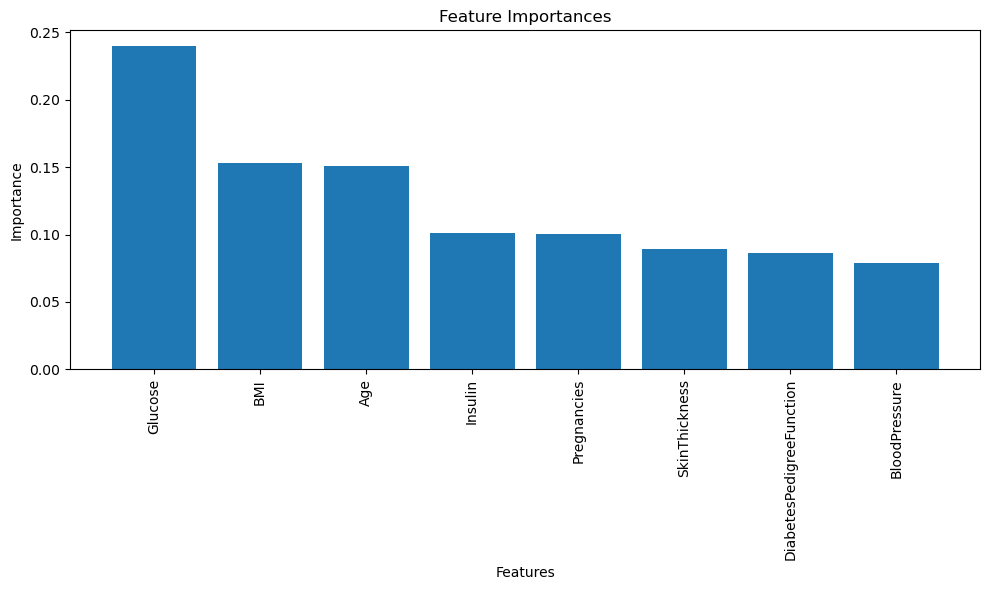

In [38]:
# Get feature importances from the model
importances = best_model_bayes.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


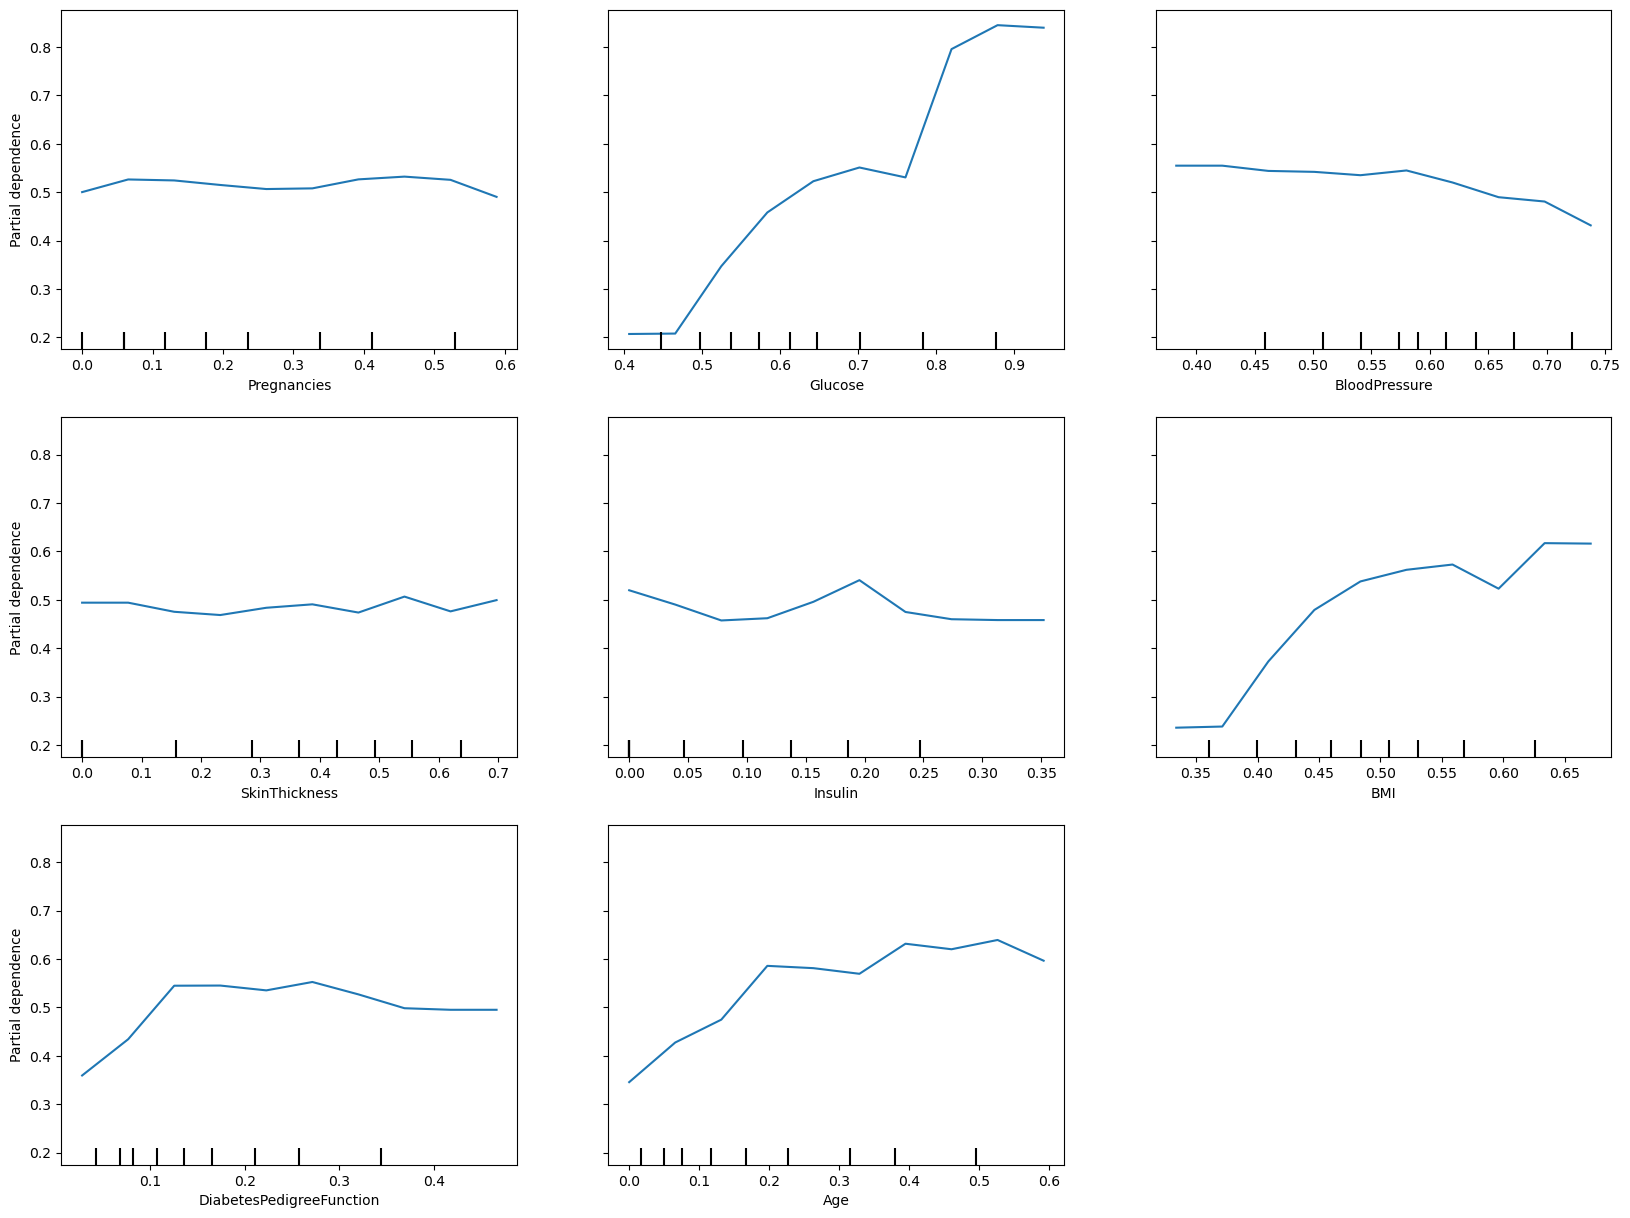

In [41]:
# Define the features to plot
features = list(range(X_train.shape[1]))  # Create a list of all feature indices

# Set up the figure with a larger size to accommodate all plots and labels
fig, ax = plt.subplots(figsize=(20, 15))

# Plot the Partial Dependence Plots with adjusted layout
display = PartialDependenceDisplay.from_estimator(
    best_model_bayes,           # Your trained model
    X_train_scaled_res,         # Scaled training data
    features,                   # Features to plot
    feature_names=X.columns,    # Feature names
    grid_resolution=10,         # Resolution of the grid (more points = more detail)
    ax=ax                       # Use the ax to control layout
)

# Show the plots
plt.show()


https://medium.com/@innohgicheru/a-step-by-step-guide-to-implement-shap-in-python-for-xai-and-machine-learning-5c32df5a70b5

https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137